In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
import os
import math
import shutil
import pandas as pd
import random

2025-07-05 08:04:22.099090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751702662.283265      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751702662.337621      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH = '/kaggle/input/asvpoof-2019-dataset/LA/LA'

# change here
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt', sep=" ", header=None)

train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)

#change here
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'

train_df['target'] = (train_df.class_name=='spoof').astype('int32')
print('len Train', len(train_df))
train_df.head()

len Train 25380


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
1,LA_0079,LA_T_1271820,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
2,LA_0079,LA_T_1272637,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
3,LA_0079,LA_T_1276960,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
4,LA_0079,LA_T_1341447,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0


In [3]:
playpath = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/LA_D_1001095.flac'
y, sr = librosa.load(playpath, sr=16000)
duration = len(y) / sr
print(duration)

3.9170625


In [4]:
### for creating folders for dev and eval
# change here
dev_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ", header=None)

dev_df.columns =['speaker_id','filename','system_id','null','class_name']
dev_df.drop(columns=['null'],inplace=True)

#change here
dev_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+dev_df.filename+'.flac'

dev_df['target'] = (dev_df.class_name=='spoof').astype('int32')
print('len dev', len(dev_df))
dev_df.head()

len dev 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
1,LA_0069,LA_D_1105538,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
2,LA_0069,LA_D_1125976,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
3,LA_0069,LA_D_1293230,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0
4,LA_0069,LA_D_1340209,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,0


In [5]:
bonafide_df = train_df[train_df["target"] == 0]
spoof_df = train_df[train_df["target"] == 1].sample(n=len(bonafide_df), random_state=42)
balanced_df = pd.concat([bonafide_df, spoof_df], ignore_index=True).sample(frac=1, random_state=42)
len(balanced_df)
train_df=balanced_df

In [6]:
# save_mfcc(balanced_df, TRAIN_JSON_PATH, num_segments=2)

In [7]:
bonafide_df = dev_df[dev_df["target"] == 0]
spoof_df = dev_df[dev_df["target"] == 1].sample(n=len(bonafide_df), random_state=42)
balanced_df = pd.concat([bonafide_df, spoof_df], ignore_index=True).sample(frac=1, random_state=42)
len(balanced_df)
val_df= balanced_df

In [8]:
# save_mfcc(balanced_df, VAL_JSON_PATH, num_segments=2)

### Run from here

In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
import os
import math
import shutil
import pandas as pd
import random

In [10]:
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 4  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [11]:
import os
import math
import json
import librosa
import numpy as np

max_time_steps = 109  # Define the maximum time steps for your model

def save_mel(train_df):
    X = []
    y = []
    for _, row in train_df.iterrows():
        file_path = row["filepath"]
        label = int(row["target"])

        try:
            # Load audio file using librosa
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
            # Extract Mel spectrogram using librosa
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
            # Ensure all spectrograms have the same width (time steps)
            if mel_spectrogram.shape[1] < max_time_steps:
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
            else:
                mel_spectrogram = mel_spectrogram[:, :max_time_steps]
        
            X.append(mel_spectrogram)
            y.append(label)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Save JSON
    # with open(json_path, "w") as fp:
    #     json.dump(data, fp, indent=4)
    return X,y


In [12]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    print(len(X))
    return X, y

def prepare_datasets(xtrain, ytrain, test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(len(xtrain))
    print(len(X_train))
    print(len(X_test))
    print(len(X_validation))
    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [13]:
TRN_PATH = '/kaggle/input/asvspoof2019-mfcc-ms-zcr/data_train (2).json'
V_PATH = '/kaggle/input/asvspoof2019-mfcc-ms-zcr/data_val (2).json'

In [14]:
x_t, y_t = save_mel(train_df)
x_v, y_v = save_mel(val_df)

In [15]:
# import json
# x_t = np.array(x_t)
# y_t = np.array(y_t)
# # Convert to standard Python types
# data = {
#     "feature": x_t.tolist(),
#     "label": y_t.tolist()
# }

# # Save to a JSON file
# with open("x_y_train.json", "w") as f:
#     json.dump(data, f)

In [16]:
# x_v = np.array(x_v)
# y_v = np.array(y_v)
# # Convert to standard Python types
# data = {
#     "feature": x_v.tolist(),
#     "label": y_v.tolist()
# }

# # Save to a JSON file
# with open("x_y_val.json", "w") as f:
#     json.dump(data, f)

In [17]:
# x_t, y_t = load_data(TRN_PATH)
# x_v, y_v = load_data(V_PATH)
# X_train = np.concatenate((x_t, x_v), axis=0)
# y_train = np.concatenate((y_t, y_v), axis=0)


In [18]:
# get train, validation, test splits

X_train = np.array(x_t)
y_train = np.array(y_t)
X_validation = np.array(x_v)
y_validation = np.array(y_v)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.3, random_state=7)

# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=7)
print(len(X_train))
print(len(X_validation))

5160
3567


In [19]:
# X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X_train, y_train, 0.2, 0.2)

In [20]:
X_train.shape

(5160, 128, 109)

In [21]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import LSTM

def build_CNN_LSTM_model(input_shape):
    model = keras.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape,
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.05))

    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.1))

    # Reshape for LSTM: (batch, time, features)
    model.add(layers.Permute((2, 1, 3)))  # (batch, freq, time, channels)
    model.add(layers.Reshape((-1, 64)))  # (batch, time, features)

    # LSTM Layer
    model.add(layers.Bidirectional(LSTM(64, return_sequences=False)))
    model.add(layers.Dropout(0.3))

    # Dense Layer
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=regularizers.l2(1e-3)))
    model.add(layers.Dropout(0.3))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import LSTM


indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]



# create network
input_shape = (X_train.shape[1], X_train.shape[2],1) # 130, 13
model = build_CNN_LSTM_model(input_shape)

    
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00025)
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
model.compile(optimizer=optimiser,
          loss='binary_crossentropy',
          metrics=['accuracy', 
                   keras.metrics.Recall()]
             )

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30,callbacks=[early_stopping],
)

# evaluate model on test set
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751702886.493528      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 109, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 55, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 55, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 28, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 896, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,697 (397.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30


E0000 00:00:1751702894.471057      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751702895.239426      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.6814 - loss: 0.7636 - recall: 0.6385 - val_accuracy: 0.7227 - val_loss: 0.6267 - val_recall: 0.8595
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8328 - loss: 0.5317 - recall: 0.7723 - val_accuracy: 0.8677 - val_loss: 0.4751 - val_recall: 0.8118
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8735 - loss: 0.4401 - recall: 0.8125 - val_accuracy: 0.9027 - val_loss: 0.3734 - val_recall: 0.8301
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8824 - loss: 0.4015 - recall: 0.8325 - val_accuracy: 0.9209 - val_loss: 0.3487 - val_recall: 0.8606
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8908 - loss: 0.3884 - recall: 0.8473 - val_accuracy: 0.9246 - val_loss: 0.3014 - val_recall: 0.8790
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9066 - loss: 0.3385 - recall: 0.8724 - val_accuracy: 0.9187 - val_loss: 0.3065 - val_recall: 0.84

In [23]:
model.save("/kaggle/working/audio_cnn_lstm.h5")

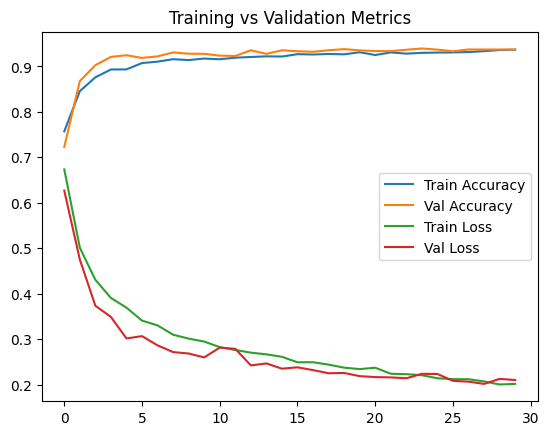

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Metrics")
plt.show()

In [25]:
test_loss, test_acc, test_recall = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

48/48 - 2s - 36ms/step - accuracy: 0.9366 - loss: 0.1906 - recall: 0.8822

Test accuracy: 0.9365598559379578


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
y_pred_probs_val = model.predict(X_validation)  # shape: (num_samples,)

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_probs_val)
fnr = 1 - tpr  # False Negative Rate

# Find the point where FPR and FNR are closest
eer_threshold_index = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_threshold_index] + fnr[eer_threshold_index]) / 2
eer_threshold = thresholds[eer_threshold_index]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
Equal Error Rate (EER): 0.0606
EER Threshold: 0.2394


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


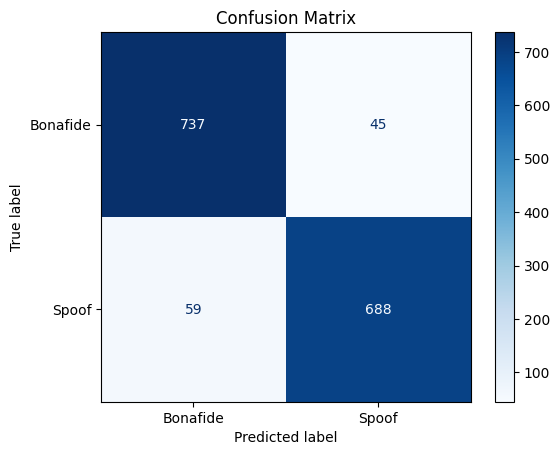

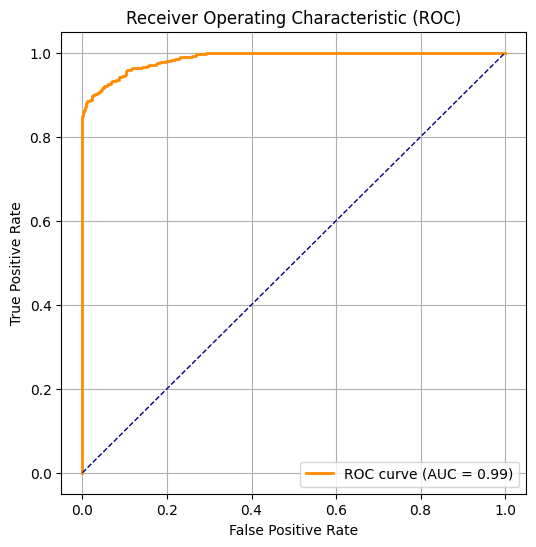

AUC Score: 0.9868


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns


y_pred_probs = model.predict(X_test) 
threshold = 0.5
y_pred = (y_pred_probs >= eer_threshold).astype(int)

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 5️⃣ ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

In [28]:
# Compute FPR, TPR, thresholds
fnr = 1 - tpr  # False Negative Rate

# Find the point where FPR and FNR are closest
eer_threshold_index = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_threshold_index] + fnr[eer_threshold_index]) / 2
eer_threshold = thresholds[eer_threshold_index]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

from sklearn.metrics import f1_score

# Use thresholded predictions
f1 = f1_score(y_test, y_pred)  # or y_pred_eer if using EER threshold

print(f"F1 Score: {f1:.4f}")

Equal Error Rate (EER): 0.0693
EER Threshold: 0.2104
F1 Score: 0.9297


In [29]:
### for creating folders for eval and dev
# change here
;
eval_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=" ", header=None)

eval_df.columns =['speaker_id','filename','system_id','null','class_name']
eval_df.drop(columns=['null'],inplace=True)

#change here
eval_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+eval_df.filename+'.flac'

eval_df['target'] = (eval_df.class_name=='spoof').astype('int32')
print('len eval', len(eval_df))
eval_df.head()

len eval 71237


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0039,LA_E_2834763,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1
1,LA_0014,LA_E_8877452,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1
2,LA_0040,LA_E_6828287,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1
3,LA_0022,LA_E_6977360,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1
4,LA_0031,LA_E_5932896,-,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...,1


In [30]:
bonafide_df = eval_df[eval_df["target"] == 0]
spoof_df = eval_df[eval_df["target"] == 1].sample(n=len(bonafide_df), random_state=42)
balanced_df = pd.concat([bonafide_df, spoof_df], ignore_index=True).sample(frac=1, random_state=42)
print(len(balanced_df))
eval_df= balanced_df

14710


In [31]:
eval_sample = eval_df.sample(n=1000, random_state=42).reset_index(drop=True)

# Step 2: Run your feature extraction function
X_test1, y_test1 = save_mel(eval_sample)

In [32]:
# import json
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# # Convert to standard Python types
# data = {
#     "feature": X_test.tolist(),
#     "label": y_test.tolist()
# }

# # Save to a JSON file
# with open("x_y_test.json", "w") as f:
#     json.dump(data, f)

In [33]:
# X_test1=np.array(X_test)
# y_test1=np.array(y_test)

In [34]:
X_test1 = np.array(X_test1)
y_test1 = np.array(y_test1)

In [35]:
test_loss, test_acc, test_recall = model.evaluate(X_test1, y_test1, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")

32/32 - 1s - 36ms/step - accuracy: 0.8780 - loss: 0.3809 - recall: 0.7657
Test Loss: 0.3809
Test Accuracy: 0.8780
Test Recall: 0.7657
